In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import warnings
random_state = 1
warnings.filterwarnings("ignore")

#### Extract Each team informations from the collected dataset

In [94]:
file_path = "considered_features.txt"
separator = '\n'
items = []
with open(file_path, 'r') as file:
    for line in file:
        line_items = line.strip().split(separator)
        items.extend(line_items)
h2h_features = ['h2h_home_win',
                'h2h_draw',
                'h2h_away_win']
items_withouth2h = [col for col in items if col not in h2h_features]
home_features = [col for col in items_withouth2h if 'home' in col]
away_features = [col for col in items_withouth2h if 'away' in col]
own_features = [col.replace('home','own') for col in home_features]
opp_features = [col.replace('away','opp') for col in away_features]
def teams_data_in_season(df):
    home_team_features = df.groupby('homeTeam')
    away_team_features = df.groupby('awayTeam')
    teams_data = {}
    for group_name, group_data in home_team_features:
        home_df = group_data.reset_index()
        own_data = home_df[home_features].set_axis(own_features, axis=1)
        opp_data = home_df[away_features].set_axis(opp_features, axis=1)
        home_df = pd.concat([own_data,opp_data,home_df[['result', 'index']]],axis=1)
        home_df['result'] = home_df['result'].apply(lambda x: 3 if x == 1 else (1 if x == 0 else 0))
        home_df['win'] = home_df['result'].apply(lambda x: 1 if x == 3 else 0)
        teams_data[group_name] = home_df
    for group_name, group_data in away_team_features:
        away_df = group_data.reset_index()
        own_data = away_df[away_features].set_axis(own_features, axis=1)
        opp_data = away_df[home_features].set_axis(opp_features, axis=1)
        away_df = pd.concat([own_data,opp_data,away_df[['result', 'index']]],axis=1)
        away_df['result'] = away_df['result'].apply(lambda x: 0 if x == 1 else (1 if x == 0 else 3))
        away_df['win'] = away_df['result'].apply(lambda x: 1 if x == 3 else 0)
        stacked = pd.concat([teams_data[group_name], away_df], axis=0)
        sorted = stacked.sort_values('index').reset_index(drop=True)
        sorted.drop(['ownTeam','oppTeam','yellow_cards_own', 'red_cards_own','yellow_cards_opp', 'red_cards_opp'], axis=1, inplace=True)
        teams_data[group_name] = sorted
    return teams_data

#### Create the transformers of the data

In [95]:
def win_streak(col):
    streak = pd.Series([0] * col.size)
    current_streak = 0
    for i, value in enumerate(col):
        if value == 1:
            current_streak += 1
        else:
            current_streak = 0
        streak[i] = current_streak
    return streak



def converter(df, rows_to_drop,window):
    converted = pd.DataFrame()
    row_indices = df.index + 1


    df['goals_ratio_own'] = np.where(df['ShotsOnTarget_own'] == 0, 0, df['ownScore'] / df['ShotsOnTarget_own'])
    df['goals_ratio_opp'] = np.where(df['ShotsOnTarget_opp'] == 0, 0, df['oppScore']/df['ShotsOnTarget_opp'])
    df['shotsOT_shots_ratio_own'] = np.where(df['total_shots_own'] == 0, 0, df['ShotsOnTarget_own']/df['total_shots_own'])
    df['shotsOT_shots_ratio_opp'] = np.where(df['total_shots_opp'] == 0, 0, df['ShotsOnTarget_opp']/df['total_shots_opp'])
    df['shotsOffT_shots_ratio_own'] = np.where(df['total_shots_own'] == 0, 0, df['ShotsOffTarget_own']/df['total_shots_own'])
    df['shotsOffT_shots_ratio_opp'] = np.where(df['total_shots_opp'] == 0, 0, df['ShotsOffTarget_opp']/df['total_shots_opp'])
    df['our_blocked_shots_ratio_own'] = np.where(df['total_shots_own'] == 0, 0, df['blocked_shots_own']/df['total_shots_own'])
    df['blocked_shots_ratio_opp'] = np.where(df['total_shots_opp'] == 0, 0, df['blocked_shots_opp']/df['total_shots_opp'])
    df['inside_box_shots_ratio_own'] = np.where(df['total_shots_own'] == 0, 0, df['shots_inside_box_own']/df['total_shots_own'])
    df['inside_box_shots_ratio_opp'] = np.where(df['total_shots_opp'] == 0, 0, df['shots_inside_box_opp']/df['total_shots_opp'])
    df['opposition_passes_own'] = np.where(df['passes_own'] == 0, 0, df['opposition_half_passes_own']/df['passes_own'])
    df['opposition_passes_opp'] = np.where(df['passes_opp'] == 0, 0, df['opposition_half_passes_opp']/df['passes_opp'])
    df['we_blocked_shots_own'] = np.where(df['total_shots_opp'] == 0, 0, df['shot_blocks_own']/df['total_shots_opp'])
    df['we_blocked_shots_opp'] = np.where(df['total_shots_own'] == 0, 0, df['shot_blocks_opp']/df['total_shots_own'])
    df['keeper_saves_ratio_own'] = np.where(df['ShotsOnTarget_opp'] == 0, 0, df['keeper_saves_own']/df['ShotsOnTarget_opp'])
    df['keeper_saves_ratio_opp'] = np.where(df['ShotsOnTarget_own'] == 0, 0, df['keeper_saves_opp']/df['ShotsOnTarget_own'])
    df['passing_efficiency_own'] = (df['accurate_passes_percentage_own']+ df['BallPossesion_own'])/2
    df['passing_efficiency_opp'] = (df['accurate_passes_percentage_opp']+ df['BallPossesion_opp'])/2
    df['offensive_efficiency_own'] = (df['ownScore']+ df['ShotsOnTarget_own'] + df['accurate_crosses_own'])/3
    df['offensive_efficiency_opp'] = (df['oppScore']+ df['ShotsOnTarget_opp'] + df['accurate_crosses_opp'])/3
    df['defensive_efficiency_own'] = (df['interceptions_own']+ df['tackles_succeeded_own'] + df['clearances_own'])/3
    df['defensive_efficiency_opp'] = (df['interceptions_opp']+ df['tackles_succeeded_opp'] + df['clearances_opp'])/3


    for col in df.columns:
        if col not in ['index']:
            converted[f'{col}_last_{window}_matches'] = df[col].rolling(window=window, min_periods=1).mean()
            converted[f'{col}_overall'] = df[col].cumsum() / row_indices
    converted['win_streak'] = win_streak(df['win'])
    final = converted[:-1]
    final['match_id']= df['index'].iloc[1:].tolist()
    final = final.set_index('match_id')
    rows_to_drop.update(df['index'][:window].tolist())
    return final

#### Extract The wanted information for each team

In [96]:
def teams_extract(teams_data,window):
    rows_to_drop = set()
    extracted_data = {}
    for team in teams_data.keys():
        extracted_data[team] = converter(teams_data[team], rows_to_drop,window)
    return extracted_data, rows_to_drop

#### Create The new rows

In [97]:
def season_dataset(row, extracted):
    home_data = extracted[row['homeTeam']].loc[row['match_id']].add_suffix('_home')
    away_data = extracted[row['awayTeam']].loc[row['match_id']].add_suffix('_away')
    new_row = pd.concat([row, home_data , away_data], axis=0)
    return new_row

#### Transformer of each season

In [99]:
def season_extracted(df,window):
    rows_to_drop = set(df[df.isna().any(axis=1)].index)
    season_data = df.dropna()
    teams_data = teams_data_in_season(season_data)
    extracted_teams, todrop = teams_extract(teams_data,window)
    season_data = season_data.drop(todrop - rows_to_drop)
    season_data = season_data[['result', 'homeTeam', 'awayTeam', 'homeScore', 'awayScore'] + h2h_features].reset_index().rename(
        columns={'index': 'match_id'})
    final = pd.DataFrame(season_data.apply(season_dataset, axis=1, args=(extracted_teams,))).drop('match_id', axis=1)
    return final

#### Create The required Dataset

In [100]:
from tqdm import tqdm
from time import time

In [101]:
def csv_generator(path,window):
    seasons = os.listdir(path)
    concatenated = pd.DataFrame()
    for file in tqdm(seasons):
        season = pd.read_csv(f'{path}/{file}')
        season = season[items]
        required_dataset = season_extracted(season,window)
        concatenated = pd.concat([concatenated, required_dataset])
    concatenated.reset_index(drop=True, inplace=True)
    return concatenated

#### Instantiate a dataset with a window = 5

In [102]:
before = time()
data = csv_generator('../data/scrapped/footmob',5)
print('It took ',(time() - before)/60,' minutes!')

100%|██████████| 125/125 [04:31<00:00,  2.17s/it]

It took  4.517963631947835  minutes!


#### Our final transformed dataset contains 36886 matches where each match defined by 330 features.

In [104]:
data

,result,homeTeam,awayTeam,homeScore,awayScore,h2h_home_win,h2h_draw,h2h_away_win,ownScore_last_5_matches_home,ownScore_overall_home,...,passing_efficiency_opp_overall_away,offensive_efficiency_own_last_5_matches_away,offensive_efficiency_own_overall_away,offensive_efficiency_opp_last_5_matches_away,offensive_efficiency_opp_overall_away,defensive_efficiency_own_last_5_matches_away,defensive_efficiency_own_overall_away,defensive_efficiency_opp_last_5_matches_away,defensive_efficiency_opp_overall_away,win_streak_away
0,0,KV Mechelen,Royal Excel Mouscron,2,2,9.0,2.0,1.0,1.8,1.800000,...,71.600000,2.866667,2.866667,3.066667,3.066667,14.133333,14.133333,12.066667,12.066667,1.0
1,2,Eupen,St.Truiden,0,2,7.0,8.0,6.0,0.6,0.600000,...,67.200000,1.866667,1.866667,4.333333,4.333333,12.866667,12.866667,10.666667,10.666667,0.0
2,0,Kortrijk,Oostende,2,2,10.0,4.0,10.0,2.0,2.000000,...,73.800000,3.066667,3.066667,4.200000,4.200000,17.000000,17.000000,11.600000,11.600000,1.0
3,1,Anderlecht,Standard Liege,1,0,11.0,9.0,14.0,0.6,0.600000,...,64.200000,5.466667,5.466667,1.933333,1.933333,11.600000,11.600000,12.600000,12.600000,2.0
4,1,Sporting Charleroi,Genk,2,1,7.0,8.0,17.0,1.8,1.800000,...,61.833333,3.933333,4.055556,3.000000,3.055556,14.066667,13.944444,13.266667,14.333333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36881,2,Pendikspor,Istanbul Basaksehir,2,3,0.0,0.0,1.0,0.6,1.096774,...,61.156250,4.200000,4.020833,2.533333,3.312500,9.800000,11.312500,12.266667,11.520833,0.0
36882,2,Hatayspor,Istanbulspor,0,3,4.0,1.0,2.0,0.8,1.161290,...,66.983871,1.866667,2.408602,5.133333,4.451613,13.133333,13.290323,9.733333,11.870968,0.0
36883,1,Rizespor,Antalyaspor,3,0,6.0,3.0,6.0,2.4,1.290323,...,64.919355,3.266667,3.430108,4.466667,3.365591,14.733333,13.247312,11.266667,12.784946,0.0
36884,2,Fatih Karagumruk,Fenerbahce,1,2,0.0,4.0,5.0,0.6,1.062500,...,57.166667,5.000000,5.259259,2.000000,2.055556,11.200000,11.814815,13.266667,15.222222,6.0


#### We don't have any missing values in our dataset

In [105]:
missing_rows = data[data.isna().any(axis=1)]
missing_rows

,result,homeTeam,awayTeam,homeScore,awayScore,h2h_home_win,h2h_draw,h2h_away_win,ownScore_last_5_matches_home,ownScore_overall_home,...,passing_efficiency_opp_overall_away,offensive_efficiency_own_last_5_matches_away,offensive_efficiency_own_overall_away,offensive_efficiency_opp_last_5_matches_away,offensive_efficiency_opp_overall_away,defensive_efficiency_own_last_5_matches_away,defensive_efficiency_own_overall_away,defensive_efficiency_opp_last_5_matches_away,defensive_efficiency_opp_overall_away,win_streak_away


<AxesSubplot:>

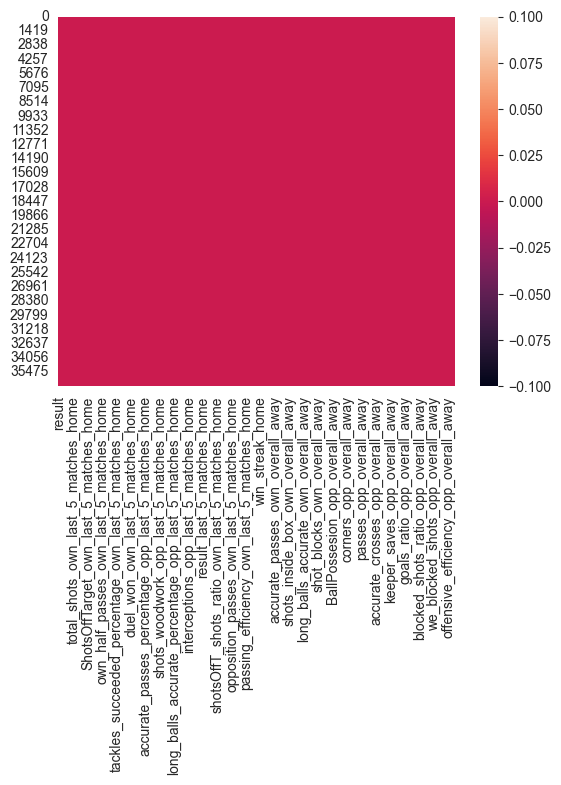

In [248]:
sns.heatmap(data.isna())

#### Searching for the best window size using Multithreading

In [9]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import threading

In [ ]:
start = time()
for i in range(2,10):
    print(f'Using a window equal {i}')
    generated = csv_generator('../data/scrapped/footmob', i)
    generated.to_csv(f'../warehouse/footmob/330features_window_{i}.csv')
print('It took ',(time() - start)/60,' minutes!')

In [13]:
csvs = os.listdir('../warehouse/footmob')

In [14]:
for i,csv in enumerate(csvs):
    data = pd.read_csv(f'../warehouse/footmob/{csv}',index_col=0)
    print(f'shape with window = {i+2} is {data.shape}')

shape with window = 2 is (40866, 330)
shape with window = 3 is (39525, 330)
shape with window = 4 is (38202, 330)
shape with window = 5 is (36886, 330)
shape with window = 6 is (35593, 330)
shape with window = 7 is (34299, 330)
shape with window = 8 is (33011, 330)
shape with window = 9 is (31745, 330)


In [ ]:
def process_csv_twice(window):
    generated = csv_generator('../data/scrapped/footmob', window)
    generated.to_csv(f'../warehouse/footmob/330features_window_{window}.csv')
    generated = csv_generator('../data/scrapped/footmob', window +1)
    generated.to_csv(f'../warehouse/footmob/330features_window_{window+1}.csv')

start = time()
threads = []
for i in range(2,10,2):
    thread = threading.Thread(target=process_csv_twice,args=(i,))
    thread.start()
    threads.append(thread)

for thread in threads:
    thread.join()

print('It took ',(time() - start)/60,' minutes!')


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]


  0%|          | 0/125 [00:00<?, ?it/s]

  1%|          | 1/125 [00:07<14:43,  7.12s/it]


  2%|▏         | 2/125 [00:18<19:27,  9.49s/it]

  2%|▏         | 2/125 [00:18<20:04,  9.79s/it]


  2%|▏         | 3/125 [00:27<18:40,  9.18s/it]

  2%|▏         | 3/125 [00:29<20:28, 10.07s/it]


  3%|▎         | 4/125 [00:35<17:46,  8.82s/it]

  3%|▎         | 4/125 [00:37<18:50,  9.35s/it]


  4%|▍         | 5/125 [00:42<16:15,  8.13s/it]

  4%|▍         | 5/125 [00:42<16:32,  8.27s/it]


  5%|▍         | 6/125 [00:50<16:20,  8.24s/it]

  5%|▍         | 6/125 [00:51<16:30,  8.32s/it]


  6%|▌         | 7/125 [00:59<16:17,  8.28s/it]

  6%|▌         | 7/125 [00:59<16:17,  8.28s/it]


  6%|▋         | 8/125 [01:06<15:46,  8.09s/it]

  6%|▋         | 8/125 [01:09<15:58,  8.19s/it]


  7%|▋         | 9/125 [01:14<15:21,  7.95s/it]

  7%|▋         | 9/125 [01:16<15:21,  7.94s/it]


  8%|▊         | 10/125 [01:24<16:

In [106]:

catboost_model = CatBoostClassifier(loss_function='MultiClass')
error_features = ['homeTeam','awayTeam','homeScore','awayScore']
def split_data(df,size):
    df1 = df[[col for col in df.columns if col not in error_features]]
    X = df1.drop('result',axis=1)
    y = df1['result']
    X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=size,random_state=random_state,stratify=y.values)
    return X_train , X_test , y_train , y_test

In [ ]:
test_scores = []
for i,csv in enumerate(csvs):
    print(f'Window = {i+2}')
    data = pd.read_csv(f'../warehouse/footmob/{csv}',index_col=0)
    X_train , X_test , y_train , y_test = split_data(data,0.2)
    catboost_model.fit(X_train,y_train)
    scored = accuracy_score(y_test,catboost_model.predict(X_test))
    test_scores.append(scored)
plt.figure()
plt.plot(np.arange(2, 2+len(test_scores)),test_scores)
plt.plot(np.argmax(test_scores)+2,max(test_scores),'ro')

In [107]:
data = pd.read_csv(f'../warehouse/footmob/330features_window_5.csv',index_col=0)
X_train , X_test , y_train , y_test = split_data(data,0.2)

In [48]:
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix

In [52]:
def model_eval(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    acc = accuracy_score(y_test, y_pred)
    print('f1 = ',f1)
    print('acc = ',acc)
    print(confusion_matrix(y_test,y_pred))

In [108]:
model_eval(catboost_model,X_train , y_train , X_test , y_test)

Learning rate set to 0.094035
0:	learn: 1.0856734	total: 203ms	remaining: 3m 22s
1:	learn: 1.0751499	total: 292ms	remaining: 2m 25s
2:	learn: 1.0662021	total: 375ms	remaining: 2m 4s
3:	learn: 1.0586761	total: 454ms	remaining: 1m 53s
4:	learn: 1.0524649	total: 542ms	remaining: 1m 47s
5:	learn: 1.0469225	total: 627ms	remaining: 1m 43s
6:	learn: 1.0420782	total: 709ms	remaining: 1m 40s
7:	learn: 1.0379366	total: 789ms	remaining: 1m 37s
8:	learn: 1.0342189	total: 870ms	remaining: 1m 35s
9:	learn: 1.0307080	total: 948ms	remaining: 1m 33s
10:	learn: 1.0278012	total: 1.03s	remaining: 1m 32s
11:	learn: 1.0252537	total: 1.11s	remaining: 1m 31s
12:	learn: 1.0228394	total: 1.21s	remaining: 1m 31s
13:	learn: 1.0207602	total: 1.28s	remaining: 1m 30s
14:	learn: 1.0185497	total: 1.37s	remaining: 1m 30s
15:	learn: 1.0161799	total: 1.46s	remaining: 1m 29s
16:	learn: 1.0145860	total: 1.53s	remaining: 1m 28s
17:	learn: 1.0129991	total: 1.6s	remaining: 1m 27s
18:	learn: 1.0116121	total: 1.69s	remaining: 1

<AxesSubplot:>

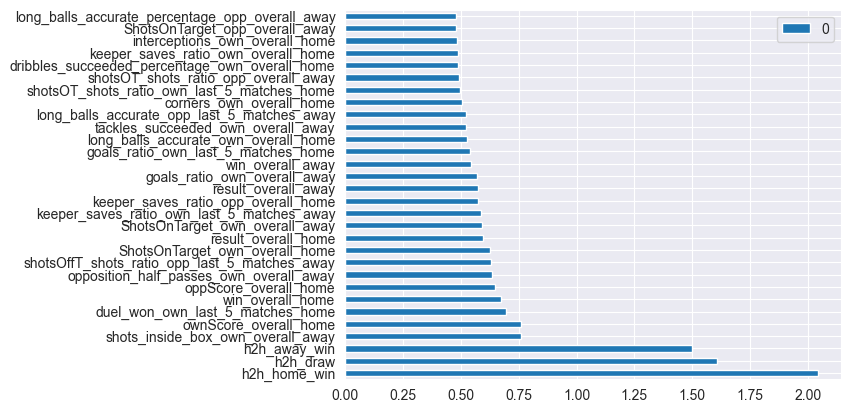

In [110]:
pd.DataFrame(catboost_model.feature_importances_, index=X_train.columns).sort_values(by=0,ascending=False)[:30].plot.barh()

In [111]:
from xgboost import XGBClassifier

In [112]:
xgc_model = XGBClassifier(random_state=random_state)

In [113]:
model_eval(xgc_model,X_train , y_train , X_test , y_test)

f1 =  0.45955355368114625
acc =  0.4898346435348333
[[ 286 1099  530]
 [ 306 2333  583]
 [ 273  973  995]]


<AxesSubplot:>

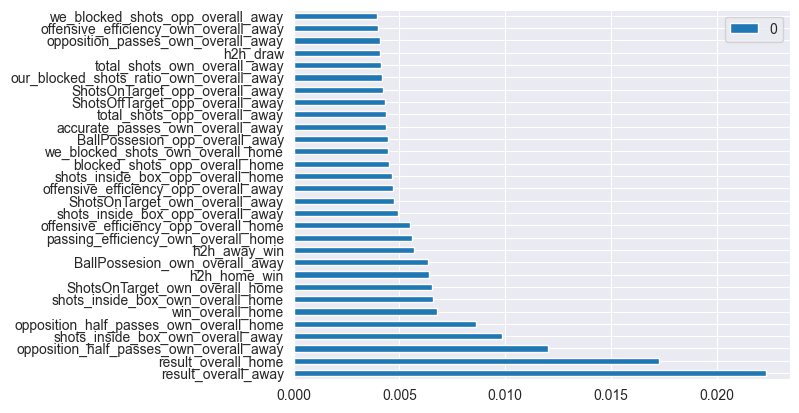

In [114]:
pd.DataFrame(xgc_model.feature_importances_, index=X_train.columns).sort_values(by=0,ascending=False)[:30].plot.barh()